# CBRAIN-CAM diagnostics

## Setup

In [264]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [265]:
%matplotlib inline
from cbrain.imports import *
from cbrain.utils import *
from matplotlib.animation import FuncAnimation
from IPython.display import SVG, HTML, FileLink

In [266]:
FIG_DIR = './figures/'
TMP_DIR = '/beegfs/DATA/pritchard/srasp/tmp/'

In [267]:
# Set colors for line plots
colors = ['#7570b3', '#d95f02', '#1b9e77']

In [268]:
def save_tmp(name, obj):
    with open(f'{TMP_DIR}{name}.pkl', 'wb') as f:
        pickle.dump(obj, f)
def load_tmp(name):
    with open(f'{TMP_DIR}{name}.pkl', 'rb') as f:
        obj = pickle.load(f)
    return obj

In [354]:
def savefigs(fig, name):
    fig.savefig(FIG_DIR + name + '.pdf')
    fig.savefig(FIG_DIR + name + '.png', dpi=300)

In [360]:
DATA_DIR = '/beegfs/DATA/pritchard/srasp/'
%ls -t {DATA_DIR}

nnatmonly_fbp8_D024_andkua_nofix_betafix35/
nnatmonly_fbp8_D025_andkua_nofix_betafix35/
fluxbypass_aqua/
tmp/
nnatmonly_fbp8_D024_andkua_allfix_betafix35_long/
wkdata/
sp8fbp_3kw1/
sp8fbp_3k/
sp8fbp_2k/
sp8fbp_1k/
sp8fbp_4k/
nonsp_3kw1/
nnatmonly_fbp8_D022_1k_allfix_betafix35/
nnatmonly_fbp8_D025_3kw1_allfix_betafix35/
nnatmonly_fbp8_D024_3kw1_allfix_betafix35/
nnatmonly_fbp8_D025_2k_allfix_betafix35/
nnatmonly_fbp8_D025_3k_allfix_betafix35/
nnatmonly_fbp8_D025_4k_allfix_betafix35/
nnatmonly_fbp8_D024_3k_allfix_betafix35/
nnatmonly_fbp8_D024_4k_allfix_betafix35/
nnatmonly_fbp8_D025_1k_allfix_betafix35/
nnatmonly_fbp8_D024_2k_allfix_betafix35/
nnatmonly_fbp8_D024_1k_allfix_betafix35/
nnatmonly_fbp8_D025_andkua_allfix_betafix35/
nnatmonly_fbp8_D024_andkua_allfix_betafix35/
nnatmonly_fbp8_D026_andkua_allfix_betafix35/
sp8fbp_andkua/
nonsp_4k/
nonsp_3k/
nonsp_2k/
nonsp_andkua/
nonsp_1k/
nnatmonly_fbp8_D021_andkua_allfix_betafix35/
nnatmonly_fbp8_D019_andkua_allfix_betafix35/
nnatmonly_fbp8

- D024: ref_4k fullyear
- D025: ref fullyear

In [363]:
exps_ak = ['sp8fbp_andkua', 'nnatmonly_fbp8_D024_andkua_allfix_betafix35', 
           'nnatmonly_fbp8_D025_andkua_allfix_betafix35', 'nonsp_andkua']
exps_ak_D024 = ['sp8fbp_andkua', 'nnatmonly_fbp8_D024_andkua_allfix_betafix35', 'nonsp_andkua']
exps_ak_D025 = ['sp8fbp_andkua', 'nnatmonly_fbp8_D025_andkua_allfix_betafix35', 'nonsp_andkua']
exps_ak_nf = ['nnatmonly_fbp8_D024_andkua_nofix_betafix35', 'nnatmonly_fbp8_D025_andkua_nofix_betafix35']
# exps_length = ['nnatmonly_fbp8_D018_andkua_allfix_betafix35', 'nnatmonly_fbp8_D019_andkua_allfix_betafix35', 
#                'nnatmonly_fbp8_D020_andkua_allfix_betafix35', 'nnatmonly_fbp8_D021_andkua_allfix_betafix35']
# exps_betafix = ['nnatmonly_fbp8_D004_andkua_allfix', 'nnatmonly_fbp8_D004_andkua_allfix_betafix25', 
#                 'nnatmonly_fbp8_D004_andkua_allfix_betafix35',  'nnatmonly_fbp8_D004_andkua_allfix_betafix5']
exps_1k = ['sp8fbp_1k', 'nnatmonly_fbp8_D024_1k_allfix_betafix35', 
           'nnatmonly_fbp8_D025_1k_allfix_betafix35', 'nonsp_1k']
exps_2k = ['sp8fbp_2k', 'nnatmonly_fbp8_D024_2k_allfix_betafix35', 
           'nnatmonly_fbp8_D025_2k_allfix_betafix35', 'nonsp_2k']
exps_3k = ['sp8fbp_3k', 'nnatmonly_fbp8_D024_3k_allfix_betafix35', 
           'nnatmonly_fbp8_D025_3k_allfix_betafix35', 'nonsp_3k']
exps_4k = ['sp8fbp_4k', 'nnatmonly_fbp8_D024_4k_allfix_betafix35', 
           'nnatmonly_fbp8_D025_4k_allfix_betafix35', 'nonsp_4k']
exps_1k_D024 = ['sp8fbp_1k', 'nnatmonly_fbp8_D024_1k_allfix_betafix35', 'nonsp_1k']
exps_2k_D024 = ['sp8fbp_2k', 'nnatmonly_fbp8_D024_2k_allfix_betafix35', 'nonsp_2k']
exps_3k_D024 = ['sp8fbp_3k', 'nnatmonly_fbp8_D024_3k_allfix_betafix35', 'nonsp_3k']
exps_4k_D024 = ['sp8fbp_4k', 'nnatmonly_fbp8_D024_4k_allfix_betafix35', 'nonsp_4k']
exps_1k_D025 = ['sp8fbp_1k', 'nnatmonly_fbp8_D025_1k_allfix_betafix35', 'nonsp_1k']
exps_2k_D025 = ['sp8fbp_2k', 'nnatmonly_fbp8_D025_2k_allfix_betafix35', 'nonsp_2k']
exps_3k_D025 = ['sp8fbp_3k', 'nnatmonly_fbp8_D025_3k_allfix_betafix35', 'nonsp_3k']
exps_4k_D025 = ['sp8fbp_4k', 'nnatmonly_fbp8_D025_4k_allfix_betafix35', 'nonsp_4k']
exps_3kw1 = ['sp8fbp_3kw1', 'nnatmonly_fbp8_D024_3kw1_allfix_betafix35', 
           'nnatmonly_fbp8_D025_3kw1_allfix_betafix35', 'nonsp_3kw1']
exps_3kw1_D024 = ['sp8fbp_3kw1', 'nnatmonly_fbp8_D024_3kw1_allfix_betafix35', 'nonsp_3kw1']
exps_3kw1_D025 = ['sp8fbp_3kw1', 'nnatmonly_fbp8_D025_3kw1_allfix_betafix35', 'nonsp_3kw1']
# exps_3kw1 = ['sp8fbp_3kw1', 'nnatmonly_fbp8_D004_3kw1_allfix', 'nonsp_3kw1']
exps = exps_ak + exps_1k + exps_2k + exps_3k + exps_4k + exps_3kw1

exps_sp = ['sp8fbp_andkua', 'sp8fbp_1k', 'sp8fbp_2k', 'sp8fbp_3k', 'sp8fbp_4k']
exps_nn_ref4k = ['nnatmonly_fbp8_D024_andkua_allfix_betafix35', 'nnatmonly_fbp8_D024_1k_allfix_betafix35', 
           'nnatmonly_fbp8_D024_2k_allfix_betafix35', 'nnatmonly_fbp8_D024_3k_allfix_betafix35', 
           'nnatmonly_fbp8_D024_4k_allfix_betafix35']
exps_nn_ref = ['nnatmonly_fbp8_D025_andkua_allfix_betafix35', 'nnatmonly_fbp8_D025_1k_allfix_betafix35', 
           'nnatmonly_fbp8_D025_2k_allfix_betafix35', 'nnatmonly_fbp8_D025_3k_allfix_betafix35', 
           'nnatmonly_fbp8_D025_4k_allfix_betafix35']
exps_nonsp = ['nonsp_andkua', 'nonsp_1k', 'nonsp_2k', 'nonsp_3k', 'nonsp_4k']

In [389]:
ds = xr.open_mfdataset(f'{DATA_DIR}nnatmonly_fbp8_D024_andkua_allfix_betafix35/*.h0.0001-*', decode_times=False) 

In [390]:
ds

<xarray.Dataset>
Dimensions:       (crm_x: 8, crm_y: 1, crm_z: 28, ilev: 31, isccp_prs: 7, isccp_prstau: 49, isccp_tau: 7, lat: 64, lev: 30, lon: 128, tbnd: 2, time: 12)
Coordinates:
  * lat           (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 ...
  * lon           (lon) float64 0.0 2.812 5.625 8.438 11.25 14.06 16.88 ...
  * crm_x         (crm_x) float64 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0
  * crm_y         (crm_y) float64 0.0
  * crm_z         (crm_z) float64 992.6 976.3 957.5 936.2 912.6 887.0 859.5 ...
  * lev           (lev) float64 3.643 7.595 14.36 24.61 38.27 54.6 72.01 ...
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 30.67 45.87 63.32 ...
  * isccp_prs     (isccp_prs) float64 90.0 245.0 375.0 500.0 620.0 740.0 900.0
  * isccp_tau     (isccp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 219.5
  * isccp_prstau  (isccp_prstau) float64 90.0 90.0 90.0 90.01 90.02 90.04 ...
  * time          (time) float64 396.0 424.0 455.0 485.0 516.0 546.0 577.0 ...
Dimensions 

In [213]:
variables = ['TAP', 'QAP', 'UAP', 'VAP', 'TPHYSTND', 'PHQ', 'PRECT', 'FSNS', 'FSNT', 'FLNS', 'FLNT', 'TS', 'TW', 'TE',
            'PS', 'P0', 'hyai', 'hybi', 'NNDQ', 'NNDT', 'gw']

In [214]:
year = '[1-5]'

In [215]:
%%time
h0s = {e : xr.open_mfdataset(f'{DATA_DIR}{e}/*.h0.000{year}-*', decode_times=False) for e in list(set(exps))}
save_tmp('saved_h0s', h0s)

CPU times: user 3min 48s, sys: 8.11 s, total: 3min 57s
Wall time: 4min 5s


In [385]:
h0s = load_tmp('saved_h0s')

In [364]:
for e in exps_ak_nf:
    h0s[e] = xr.open_mfdataset(f'{DATA_DIR}{e}/*.h0.000{year}-*', decode_times=False)

In [365]:
for ds in h0s.values():
    tmp = list(ds.data_vars)
    for v in tmp:
        if v not in variables:
            del ds[v]

In [255]:
%%time
h0means = {e: h.mean('time').compute() for e, h in h0s.items()}

CPU times: user 6min 24s, sys: 1min 17s, total: 7min 42s
Wall time: 12min 19s


In [366]:
for e in exps_ak_nf:
    h0means[e] = h0s[e].mean('time').compute()

In [221]:
save_tmp('saved_h0means', h0means)

In [10]:
h0means = load_tmp('saved_h0means')

In [386]:
for e in exps_3kw1 + exps_ak:
    h0means[e] = h0s[e].mean('time').compute()

In [ ]:
save_tmp('saved_h0means', h0means)

In [313]:
year = '[1-5]'

In [335]:
for e in exps:
    print(sorted(glob(f'{DATA_DIR}{e}/*.h1.000*'))[-1])

/beegfs/DATA/pritchard/srasp/sp8fbp_andkua/sp8fbp_andkua.cam2.h1.0007-01-06-00000.nc
/beegfs/DATA/pritchard/srasp/nnatmonly_fbp8_D024_andkua_allfix_betafix35/nnatmonly_fbp8_D024_ak_af_bf35.cam2.h1.0006-01-01-00000.nc
/beegfs/DATA/pritchard/srasp/nnatmonly_fbp8_D025_andkua_allfix_betafix35/nnatmonly_fbp8_D025_ak_af_bf35.cam2.h1.0006-01-01-00000.nc
/beegfs/DATA/pritchard/srasp/nonsp_andkua/nonsp_andkua.cam2.h1.0009-12-22-00000.nc
/beegfs/DATA/pritchard/srasp/sp8fbp_1k/sp8fbp_1k.cam2.h1.0008-01-01-00000.nc
/beegfs/DATA/pritchard/srasp/nnatmonly_fbp8_D024_1k_allfix_betafix35/nnatmonly_fbp8_D024_1k_af_bf35.cam2.h1.0006-01-01-00000.nc
/beegfs/DATA/pritchard/srasp/nnatmonly_fbp8_D025_1k_allfix_betafix35/nnatmonly_fbp8_D025_1k_af_bf35.cam2.h1.0006-01-01-00000.nc
/beegfs/DATA/pritchard/srasp/nonsp_1k/nonsp_1k.cam2.h1.0008-01-01-00000.nc
/beegfs/DATA/pritchard/srasp/sp8fbp_2k/sp8fbp_2k.cam2.h1.0005-07-05-00000.nc
/beegfs/DATA/pritchard/srasp/nnatmonly_fbp8_D024_2k_allfix_betafix35/nnatmonly_fbp8

In [343]:
%%time
h1s = {e : xr.open_mfdataset(f'{DATA_DIR}{e}/*.h1.0001-*', decode_times=False, decode_cf=False) 
       for e in exps_ak +exps_4k}
save_tmp('saved_h1s', h1s)

CPU times: user 24.4 s, sys: 347 ms, total: 24.8 s
Wall time: 1min 50s


In [372]:
for e in exps_ak_nf:
    h1s[e] = xr.open_mfdataset(f'{DATA_DIR}{e}/*.h1.0001-*', decode_times=False)

In [337]:
for ds in h1s.values():
    tmp = list(ds.data_vars)
    for v in tmp:
        if v not in variables:
            del ds[v]

In [338]:
%%time
h1stds = {e: h.isel(time=slice(0, None, 8)).std('time').compute() for e, h in h1s.items()}

CPU times: user 41.5 s, sys: 19.1 s, total: 1min
Wall time: 3min 2s


In [373]:
for e in exps_ak_nf:
    h1stds[e] = h1s[e].isel(time=slice(0, None, 8)).std('time').compute()

KeyboardInterrupt: 

In [339]:
save_tmp('h1stds', h1stds)

In [8]:
# h1s = load_tmp('saved_h1s')

In [107]:
def compare(func, exps, ref=None, title=None, hs=h0means, **kwargs):
    npanels = len(exps) if ref is None else len(exps) + 1
    ncols=min(3, npanels); nrows=int(np.ceil(npanels/ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(13.5, 4*nrows));
    if ref is None:
        [func(hs[e]).plot(ax=ax, **kwargs) for e, ax in zip(exps, axs.flat)]
        [ax.set_title(e) for e, ax in zip(exps, axs.flat)]
    else:
        yi = kwargs['yincrease'] if 'yincrease' in kwargs.keys() else None
        func(hs[ref]).plot(ax=axs.flat[0], yincrease=yi); axs.flat[0].set_title(ref)
        [(func(hs[e])-func(hs[ref]).values).plot(ax=ax, **kwargs) for e, ax in zip(exps, axs.flat[1:])]
        [ax.set_title(f'{e} - {ref}'[-50:]) for e, ax in zip(exps, axs.flat[1:])]
    if title is None: plt.tight_layout()
    else: fig.suptitle(title); plt.tight_layout(rect=(0, 0, 1, 0.95))
    return fig, axs

In [379]:
def compare_line(func, exps, hs, ax=None, legend=True, **kwargs):
    if ax is None: fig, ax = plt.subplots(figsize=(6, 5))
    [func(hs[e]).plot(ax=ax, label=e, **kwargs) for e in exps]
    if legend: ax.legend()

In [109]:
def climate_error(meanf, errf, ref, exps):
    means = [meanf(h0s[e]) for e in [ref] + exps]
    err = [errf(means[0], means[i]) for i in range(1, len(means))]
    stats = [vint(means[0], da, 1) for da in err]
    stats = [gw_avg(means[0], '', da).compute() for da in stats]
    return stats

In [16]:
inchincm = 2.45
#pagewidth = 18.3/inchincm # Inches
pagewidth = 2.25*3 + 0.5
onecol = 2.25
twocols = 4.75
pagewidth

7.25

In [51]:
FONTSIZE = 7
plt.rc('font', size=FONTSIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONTSIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONTSIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONTSIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONTSIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONTSIZE)    # legend fontsize
plt.rc('figure', titlesize=FONTSIZE)  # fontsize of the figure title

## Mean climate and parameterized tendencies

In [42]:
# Gaussian latitudes
lats = h0s[exps_ak[0]].lat.values
gw = h0s[exps_ak[0]].gw.isel(time=1)
gwsum = np.cumsum(gw.values)

In [45]:
label_lats = [-60, -30, 0, 30, 60]
gw_lats = [np.interp(l, lats, gwsum) for l in label_lats]

In [46]:
def mean_panels(hdict, func, exps, exp_ref=None, vmin=-5, vmax=5, cm_ref='plasma', cm='RdBu_r', unit='Temperature [K]', 
                contourf=False, levels_ref=None, levels=None, clevels=None, clabel_locs=[], clabel_fmt='%.0f', 
                clev_color='white', width=twocols, height=2.2, titles=None):
    has_ref = int(exp_ref is not None)
    npanels = len(exps) + has_ref
    fig, axs = plt.subplots(1, npanels, figsize=(width, height))
    
    if has_ref:
        da_ref = func(hdict[exp_ref]); da_ref['lat'] = gwsum
        if contourf:
            da_ref.plot.contourf(ax=axs[0], yincrease=False, add_colorbar=False, cmap=cm_ref, levels=levels_ref)
            if clevels is not None:
                cs = da_ref.plot.contour(ax=axs[0], yincrease=False, add_colorbar=False, levels=clevels, 
                                         colors=clev_color, linewidths=1)
                plt.clabel(cs, fmt=clabel_fmt, manual=clabel_locs)
        else:
            da_ref.plot(ax=axs[0], yincrease=False, add_colorbar=False, cmap=cm_ref)
    
    for ax, exp in zip(axs.flat[has_ref:], exps):
        da = func(hdict[exp]); da['lat'] = gwsum
        if has_ref: da -= da_ref
        if contourf:
            im = da.plot.contourf(ax=ax, yincrease=False, add_colorbar=False, cmap=cm, levels=levels)
        else:
            im = da.plot(ax=ax, yincrease=False, add_colorbar=False, vmin=vmin, vmax=vmax, cmap=cm)
            
    [ax.set_xticks(gw_lats) for ax in axs.flat]; [ax.set_xticklabels(label_lats) for ax in axs.flat]; 
    [ax.set_yticks([]) for ax in axs.flat[1:]]; [ax.set_ylabel('') for ax in axs.flat[1:]];
    axs[0].set_ylabel('Pressure [hPa]'); [ax.set_xlabel('Latitude') for ax in axs.flat]
    if titles is not None: [ax.set_title(titles[i]) for i, ax in enumerate(axs.flat)]
    
    plt.subplots_adjust(wspace=0.03, left=0.1, right=1.0, bottom=0.2)
    cb = fig.colorbar(im, ax=axs.flat, pad=0.01, extend='both', use_gridspec=False); cb.set_label(unit)
    cb.formatter.set_powerlimits((1, 10)); cb.update_ticks()
    cb.ax.yaxis.set_offset_position('left')
    
    return fig

### Nofix runs

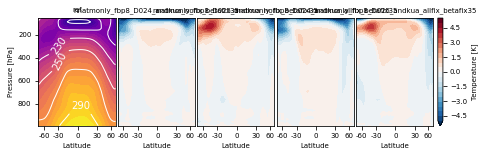

In [371]:
f = mean_panels(h0means, lambda d: d['TAP'].isel(lev=slice(5, None)).mean('lon'), 
                exps_ak_nf + [exps_ak_D024[1]] + [exps_ak_D025[1]], exps_ak[0], 
                    contourf=True, width=pagewidth, 
               titles=['ref'] + exps_ak_nf + [exps_ak_D024[1]] + [exps_ak_D025[1]],
                    clevels=np.arange(190, 310, 20), levels_ref=np.arange(180, 305, 5), 
                    levels=np.arange(-5, 6, 0.5), clabel_locs=clabel_locs)

### Warming

In [49]:
sst_titles = ['+0K', '+1K', '+2K', '+3K', '+4K']

In [47]:
clabel_locs = [(1, 180), (1, 200), (1, 400), (1, 600), (1, 900)]

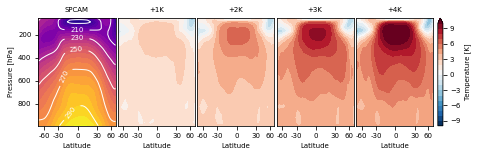

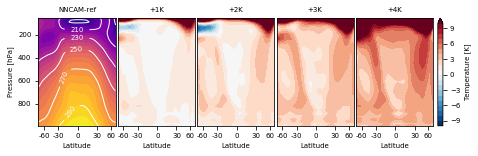

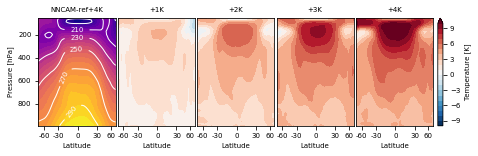

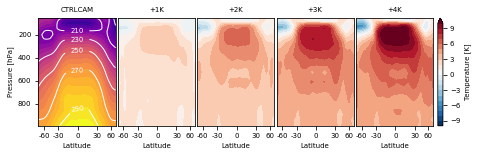

In [52]:
for name, exps in zip(['SPCAM', 'NNCAM-ref', 'NNCAM-ref+4K', 'CTRLCAM'], 
                      [exps_sp, exps_nn_ref, exps_nn_ref4k, exps_nonsp]):
    f = mean_panels(h0means, lambda d: d['TAP'].isel(lev=slice(5, None)).mean('lon'), exps[1:], exps[0], 
                    contourf=True, width=pagewidth, titles=[name] + sst_titles[1:], 
                    clevels=np.arange(190, 310, 20), levels_ref=np.arange(180, 305, 5), 
                    levels=np.arange(-10, 11, 1), clabel_locs=clabel_locs)
    f.savefig(f'{FIG_DIR}warming_T_{name}.pdf')
    plt.show()

In [55]:
clabel_locs = [(0.2, 900), (0.7, 900)]

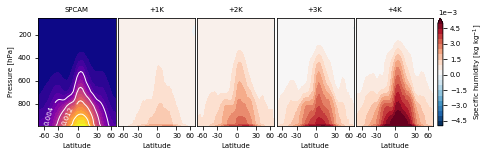

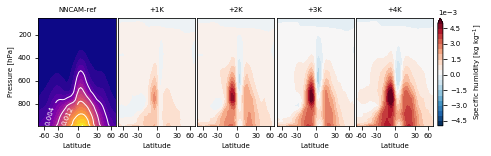

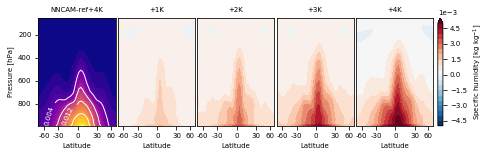

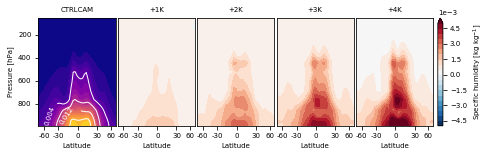

In [56]:
for name, exps in zip(['SPCAM', 'NNCAM-ref', 'NNCAM-ref+4K', 'CTRLCAM'], 
                      [exps_sp, exps_nn_ref, exps_nn_ref4k, exps_nonsp]):
    f = mean_panels(h0means, lambda d: d['QAP'].isel(lev=slice(5, None)).mean('lon'), exps[1:], exps[0], 
                    contourf=True, width=pagewidth, titles=[name] + sst_titles[1:], 
                    clevels=np.arange(0, 0.024, 0.004), levels_ref=np.arange(0, 0.021, 0.001), clabel_fmt='%.3f',
                    levels=np.arange(-0.005, 0.0055, 0.0005), clabel_locs=clabel_locs, unit=r'Specific humidity [kg kg$^{-1}$]')
    f.savefig(f'{FIG_DIR}warming_Q_{name}.pdf')
    plt.show()

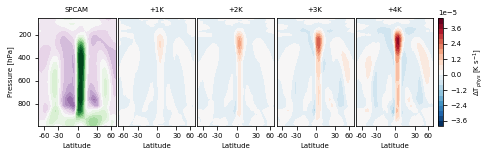

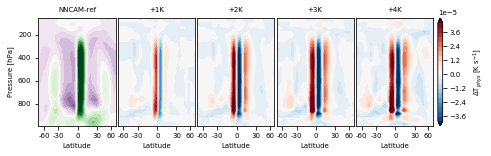

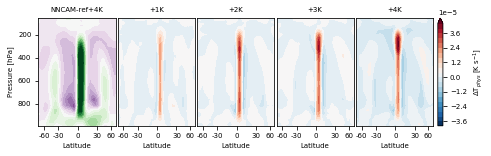

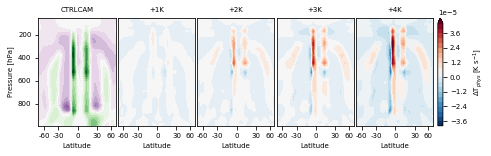

In [57]:
for name, exps in zip(['SPCAM', 'NNCAM-ref', 'NNCAM-ref+4K', 'CTRLCAM'], 
                      [exps_sp, exps_nn_ref, exps_nn_ref4k, exps_nonsp]):
    f = mean_panels(h0means, lambda d: d['TPHYSTND'].isel(lev=slice(5, None)).mean('lon'), exps[1:], exps[0], 
                    contourf=True, width=pagewidth, titles=[name] + sst_titles[1:], 
                    levels_ref=np.arange(-5e-5, 5.5e-5, 5e-6), unit='$\Delta$T$_{phys}$ [K s$^{-1}$]',
                    levels=np.arange(-4e-5, 4.4e-5, 4e-6), cm_ref='PRGn')
    f.savefig(f'{FIG_DIR}warming_TPHY_{name}.pdf')
    plt.show()

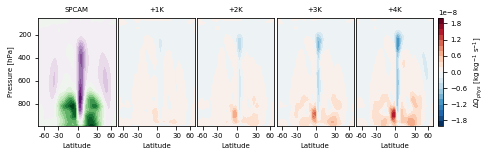

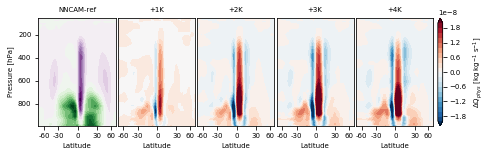

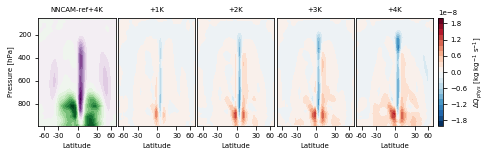

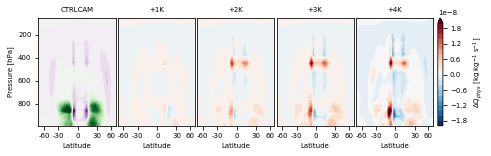

In [58]:
for name, exps in zip(['SPCAM', 'NNCAM-ref', 'NNCAM-ref+4K', 'CTRLCAM'], 
                      [exps_sp, exps_nn_ref, exps_nn_ref4k, exps_nonsp]):
    f = mean_panels(h0means, lambda d: d['PHQ'].isel(lev=slice(5, None)).mean('lon'), exps[1:], exps[0], 
                    contourf=True, width=pagewidth, titles=[name] + sst_titles[1:], 
                    levels_ref=np.arange(-3e-8, 3.3e-8, 3e-9), unit='$\Delta$Q$_{phys}$ [kg kg$^{-1}$ s$^{-1}$]',
                    levels=np.arange(-2e-8, 2.2e-8, 2e-9), cm_ref='PRGn')
    f.savefig(f'{FIG_DIR}warming_PHQ_{name}.pdf')
    plt.show()

### Training length

ValueError: dimensions or multi-index levels ['time'] do not exist

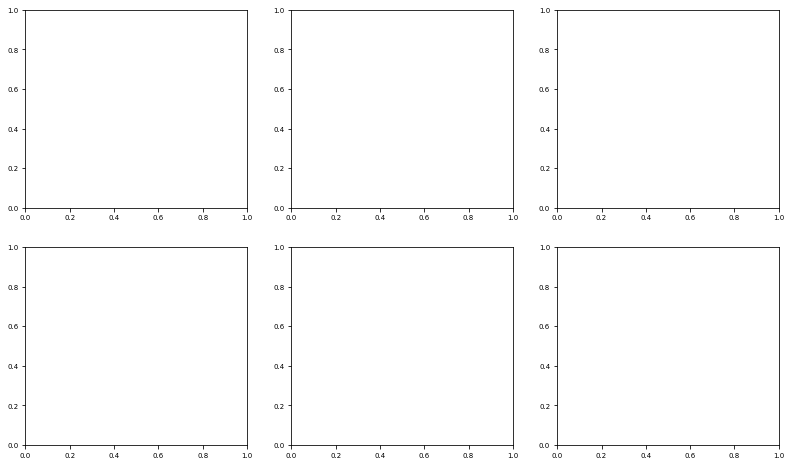

In [430]:
compare(lambda d: d['TAP'].sel(time=slice(30, None)).mean(('time', 'lon')), 
        exps_length + ['nnatmonly_fbp8_D004_andkua_allfix_betafix35'], ref=exps_ak[0], 
        yincrease=False, vmin=-5, vmax=5, cmap='RdBu_r', title='Mean Temperature');

In [ ]:
compare(lambda d: d['QAP'].sel(time=slice(30, None)).mean(('time', 'lon')), 
        exps_length + ['nnatmonly_fbp8_D004_andkua_allfix_betafix35'], ref=exps_ak[0], 
        yincrease=False, vmin=-0.002, vmax=0.002, cmap='RdBu_r', title='Mean Humidity');

In [ ]:
climerr = climate_error(
    lambda d: d.sel(time=slice(30, None)).isel(lev=slice(5, None), ilev=slice(5, None)).mean(('time')),
    lambda ref, d: np.fabs(ref['TAP'] - d['TAP']), exps_ak[0], 
    exps_length + ['nnatmonly_fbp8_D004_andkua_allfix_betafix35'])

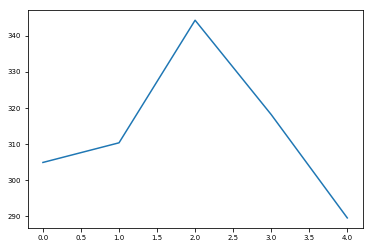

In [75]:
plt.plot(climerr)

In [76]:
climerr = climate_error(
    lambda d: d.sel(time=slice(30, None)).isel(lev=slice(5, None), ilev=slice(5, None)).mean(('time')),
    lambda ref, d: np.fabs(ref['QAP'] - d['QAP']), exps_ak[0], 
    exps_length + ['nnatmonly_fbp8_D004_andkua_allfix_betafix35'])

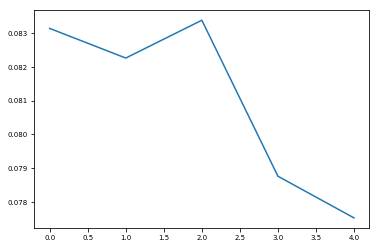

In [77]:
plt.plot(climerr)

### Temperature

In [59]:
clabel_locs = [(1, 150), (1, 200), (1, 300), (1, 500), (1, 900)]

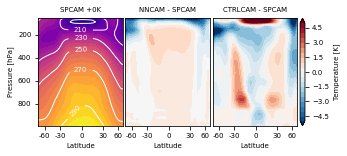

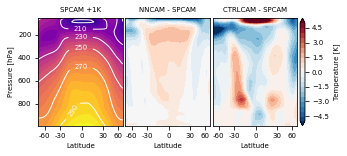

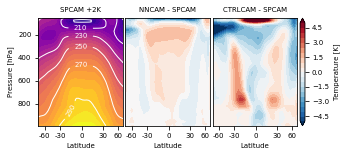

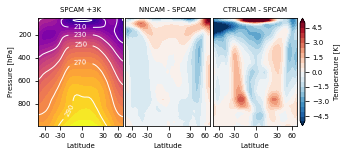

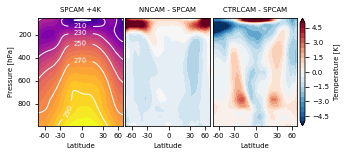

In [60]:
for name, exps in zip(['+0K', '+1K', '+2K', '+3K', '+4K'], 
                      [exps_ak_D024, exps_1k_D024, exps_2k_D024, exps_3k_D024, exps_4k_D024]):
    f = mean_panels(h0means, lambda d: d['TAP'].isel(lev=slice(5, None)).mean('lon'), exps[1:], exps[0], 
                    contourf=True, width=twocols, titles=['SPCAM ' + name, 'NNCAM - SPCAM', 'CTRLCAM - SPCAM'], 
                    clevels=np.arange(190, 310, 20), levels_ref=np.arange(180, 305, 5),
                    levels=np.arange(-5, 5.5, 0.5), clabel_locs=clabel_locs)
    f.savefig(f'{FIG_DIR}comp_T_{name}.pdf')
    plt.show()

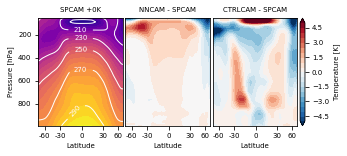

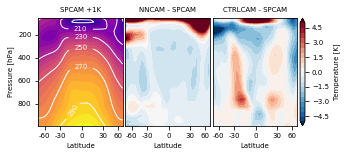

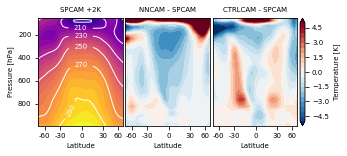

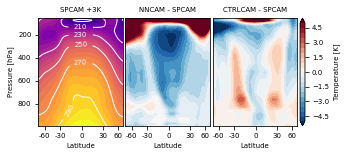

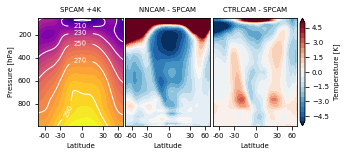

In [61]:
for name, exps in zip(['+0K', '+1K', '+2K', '+3K', '+4K'], 
                      [exps_ak_D025, exps_1k_D025, exps_2k_D025, exps_3k_D025, exps_4k_D025]):
    f = mean_panels(h0means, lambda d: d['TAP'].isel(lev=slice(5, None)).mean('lon'), exps[1:], exps[0], 
                    contourf=True, width=twocols, titles=['SPCAM ' + name, 'NNCAM - SPCAM', 'CTRLCAM - SPCAM'], 
                    clevels=np.arange(190, 310, 20), levels_ref=np.arange(180, 305, 5),
                    levels=np.arange(-5, 5.5, 0.5), clabel_locs=clabel_locs)
#     f.savefig(f'comp_T_{name}.pdf')
    plt.show()

### Humidity

In [62]:
clabel_locs = [(0.2, 900), (0.7, 900)]

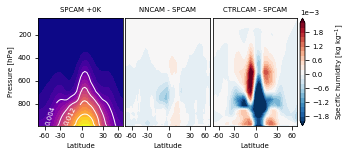

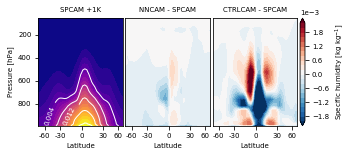

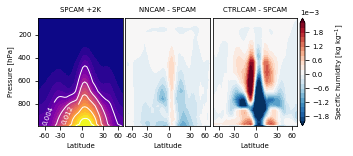

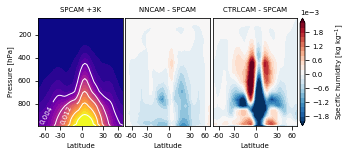

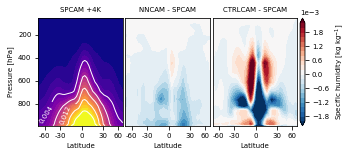

In [63]:
for name, exps in zip(['+0K', '+1K', '+2K', '+3K', '+4K'], 
                      [exps_ak_D024, exps_1k_D024, exps_2k_D024, exps_3k_D024, exps_4k_D024]):
    f = mean_panels(h0means, lambda d: d['QAP'].isel(lev=slice(5, None)).mean('lon'), exps[1:], exps[0], 
                    contourf=True, width=twocols, titles=['SPCAM ' + name, 'NNCAM - SPCAM', 'CTRLCAM - SPCAM'], 
                    clevels=np.arange(0, 0.024, 0.004), levels_ref=np.arange(0, 0.021, 0.001), clabel_fmt='%.3f',
                    levels=np.arange(-0.002, 0.0022, 0.0002), clabel_locs=clabel_locs, unit=r'Specific humidity [kg kg$^{-1}$]')
    f.savefig(f'{FIG_DIR}comp_Q_{name}.pdf')
    plt.show()

### Wind

In [64]:
clabel_locs = [(1, 700), (0.75, 450), (0.6, 300)]

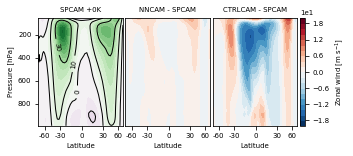

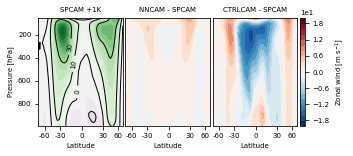

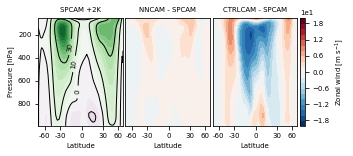

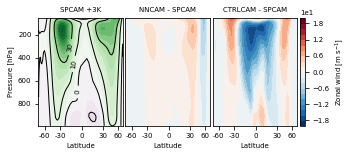

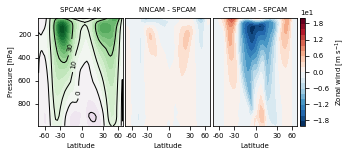

In [65]:
for name, exps in zip(['+0K', '+1K', '+2K', '+3K', '+4K'], 
                      [exps_ak_D024, exps_1k_D024, exps_2k_D024, exps_3k_D024, exps_4k_D024]):
    f = mean_panels(h0means, lambda d: d['UAP'].isel(lev=slice(5, None)).mean('lon'), exps[1:], exps[0], 
                    contourf=True, width=twocols, titles=['SPCAM ' + name, 'NNCAM - SPCAM', 'CTRLCAM - SPCAM'], 
                    clevels=[-10, 0, 10, 30], levels_ref=np.arange(-80, 85, 5), cm_ref='PRGn', clev_color='k',
                    levels=np.arange(-20, 22, 2), clabel_locs=clabel_locs, unit=r'Zonal wind [m s$^{-1}$]')
    f.savefig(f'{FIG_DIR}comp_U_{name}.pdf')
    plt.show()

### Heating

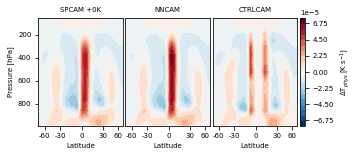

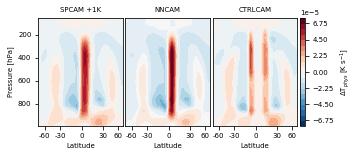

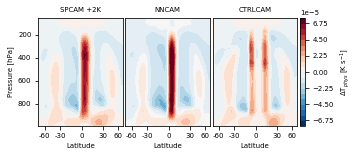

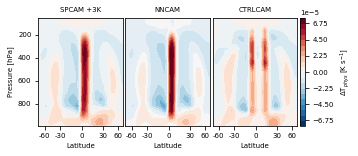

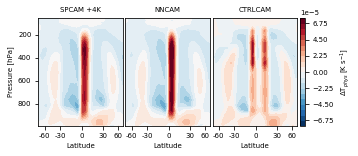

In [66]:
for name, exps in zip(['+0K', '+1K', '+2K', '+3K', '+4K'], 
                      [exps_ak_D024, exps_1k_D024, exps_2k_D024, exps_3k_D024, exps_4k_D024]):
    f = mean_panels(h0means, lambda d: d['TPHYSTND'].isel(lev=slice(5, None)).mean('lon'), exps, 
                    contourf=True, width=twocols, titles=['SPCAM ' + name, 'NNCAM', 'CTRLCAM'],
                    levels=np.arange(-7.5e-5, 8.25e-5, 7.5e-6), unit='$\Delta$T$_{phys}$ [K s$^{-1}$]')
    f.savefig(f'{FIG_DIR}comp_TPHY_{name}.pdf')
    plt.show()

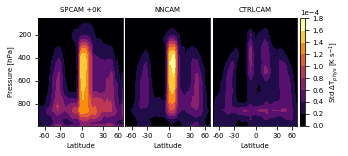

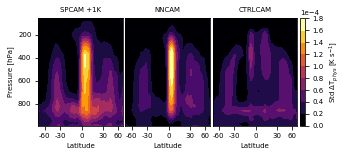

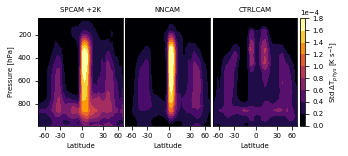

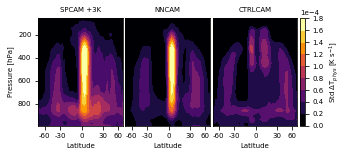

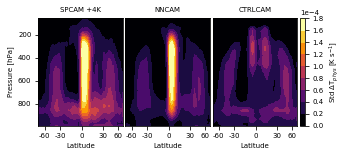

In [79]:
for name, exps in zip(['+0K', '+1K', '+2K', '+3K', '+4K'], 
                      [exps_ak_D024, exps_1k_D024, exps_2k_D024, exps_3k_D024, exps_4k_D024]):
    f = mean_panels(h1stds, lambda d: d['TPHYSTND'].isel(lev=slice(5, None)).mean('lon'), exps, 
                    contourf=True, width=twocols, titles=['SPCAM ' + name, 'NNCAM', 'CTRLCAM'],
                    levels=np.arange(0, 2e-4, 2e-5), cm='inferno', unit='Std $\Delta$T$_{phys}$ [K s$^{-1}$]')
    f.savefig(f'{FIG_DIR}comp_stdTPHY_{name}.pdf')
    plt.show()

### Moistening

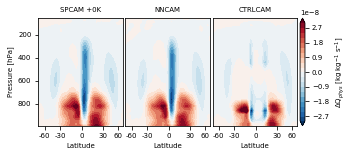

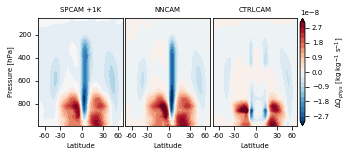

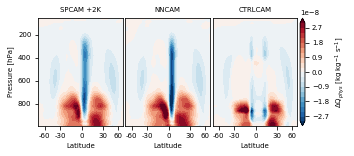

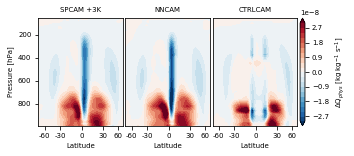

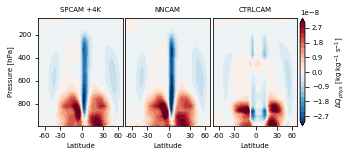

In [80]:
for name, exps in zip(['+0K', '+1K', '+2K', '+3K', '+4K'], 
                      [exps_ak_D024, exps_1k_D024, exps_2k_D024, exps_3k_D024, exps_4k_D024]):
    f = mean_panels(h0means, lambda d: d['PHQ'].isel(lev=slice(5, None)).mean('lon'), exps, 
                    contourf=True, width=twocols, titles=['SPCAM ' + name, 'NNCAM', 'CTRLCAM'],
                    levels=np.arange(-3e-8, 3.3e-8, 3e-9), unit='$\Delta$Q$_{phys}$ [kg kg$^{-1}$ s$^{-1}$]')
    f.savefig(f'{FIG_DIR}comp_PHQ_{name}.pdf')
    plt.show()

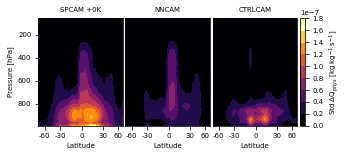

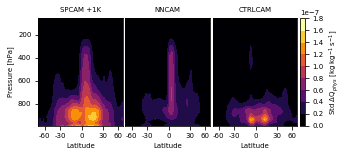

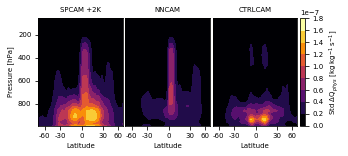

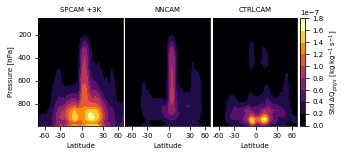

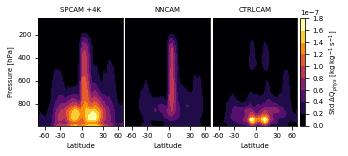

In [81]:
for name, exps in zip(['+0K', '+1K', '+2K', '+3K', '+4K'], 
                      [exps_ak_D024, exps_1k_D024, exps_2k_D024, exps_3k_D024, exps_4k_D024]):
    f = mean_panels(h1stds, lambda d: d['PHQ'].isel(lev=slice(5, None)).mean('lon'), exps, 
                    contourf=True, width=twocols, titles=['SPCAM ' + name, 'NNCAM', 'CTRLCAM'],
                    levels=np.arange(0, 2e-7, 2e-8), cm='inferno',
                    unit=r'Std $\Delta$Q$_{phys}$ [kg kg$^{-1}$ s$^{-1}$]')
    f.savefig(f'{FIG_DIR}comp_stdPHQ_{name}.pdf')
    plt.show()

### Climate error

In [256]:
def climate_error(hdict, meanf, errf, ref, exps):
    means = [meanf(hdict[e]) for e in [ref] + exps]
    err = [errf(means[0], means[i]) for i in range(1, len(means))]
    stats = [vint(means[0], da, 1) for da in err]
    stats = [gw_avg(means[0], '', da).compute() for da in stats]
    return stats

In [257]:
climerr = {v: [climate_error(h0means,
    lambda d: d.isel(lev=slice(5, None), ilev=slice(5, None)),
    lambda ref, d: np.fabs(ref[v] - d[v]), e[0], e[1:]) 
           for e in [exps_ak, exps_1k, exps_2k, exps_3k, exps_4k]] for v in ['TAP', 'QAP', 'TPHYSTND', 'PHQ']}

In [258]:
def plot_climerr(data, var='temperature', legend=True):
    fig, ax = plt.subplots(figsize=(onecol, 2.2)); plt.subplots_adjust(left=0.3, right=0.95, top=0.95, bottom=0.2)
    data = np.array(data); data /= data[0, 2]
    x = np.arange(5)
    sns.despine()
    plt.scatter(x, data[:, 1], label='NNCAM-ref', c=colors[1])
    plt.scatter(x, data[:, 0], label='NNCAM-ref+4k', edgecolors=colors[1], marker='^', c='white')
    plt.scatter(x, data[:, 2], label='CTRLCAM', c=colors[2])
    if legend: plt.legend();
    plt.ylabel(f'Normalized {var} difference')
    plt.xlabel('SST increase [K]');
    ax.set_yticklabels([])
    return fig

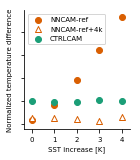

In [259]:
f = plot_climerr(climerr['TAP']); f.savefig(f'{FIG_DIR}climerr_TAP.pdf')

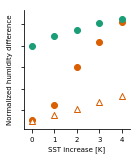

In [260]:
f = plot_climerr(climerr['QAP'], 'humidity', legend=False); f.savefig(f'{FIG_DIR}climerr_QAP.pdf')

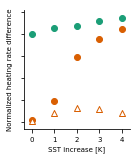

In [261]:
f = plot_climerr(climerr['TPHYSTND'], 'heating rate', False); f.savefig(f'{FIG_DIR}climerr_TPHY.pdf')

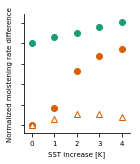

In [262]:
f = plot_climerr(climerr['PHQ'], 'moistening rate', False); f.savefig(f'{FIG_DIR}climerr_PHQ.pdf')

### Snapshots

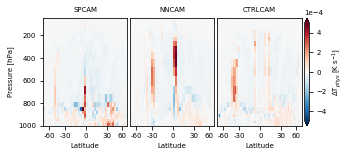

In [82]:
f = mean_panels(h1s, lambda d: d['TPHYSTND'].isel(lev=slice(5, None), lon=0, time=7), exps_ak_D024,
                contourf=False, width=twocols, titles=['SPCAM', 'NNCAM', 'CTRLCAM'], 
                vmin=-5e-4, vmax=5e-4, unit='$\Delta$T$_{phys}$ [K s$^{-1}$]')

In [83]:
f.savefig(f'{FIG_DIR}snap_TPHY.pdf')

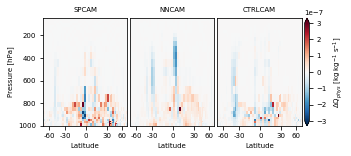

In [84]:
f = mean_panels(h1s, lambda d: d['PHQ'].isel(lev=slice(5, None), lon=0, time=7), exps_ak_D024,
                contourf=False, width=twocols, titles=['SPCAM', 'NNCAM', 'CTRLCAM'], 
                vmin=-3e-7, vmax=3e-7, unit='$\Delta$Q$_{phys}$ [kg kg$^{-1}$ s$^{-1}$]')

In [85]:
f.savefig(f'{FIG_DIR}snap_PHQ.pdf')

### Line plots

In [418]:
def mean_panels_line(hdict, vars, exps, colors, width=onecol, height=6, labels=None):
    npanels = len(vars)
    fig, axs = plt.subplots(npanels, 1, figsize=(width, height))
    if labels is None: labels = exps
    for iax, ax in enumerate(axs.flat):
        ax.set_ylabel(vars[iax] + r' [W m$^{-2}$]')
        for ie, e in enumerate(exps):
            ax.plot(gwsum, hdict[e][vars[iax]].mean('lon'), c=colors[ie], lw=2)
            
    [ax.set_xticks(gw_lats) for ax in axs.flat]; [ax.set_xticklabels(label_lats) for ax in axs.flat]; 
    axs[-1].set_xlabel('Latitude')
    [ax.set_xticklabels([]) for ax in axs.flat[:-1]]
    
    plt.subplots_adjust(wspace=0.03, hspace=0.15, left=0.2, right=1.0, bottom=0.2)    
    return fig

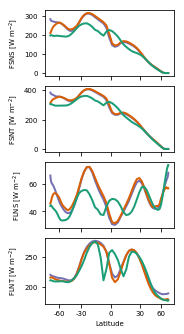

In [419]:
f = mean_panels_line(h0means, ['FSNT','FLNT'], exps_ak_D024, colors)

In [387]:
h0s['nnatmonly_fbp8_D024_andkua_allfix_betafix35']

<xarray.Dataset>
Dimensions:       (crm_x: 8, crm_y: 1, crm_z: 28, ilev: 31, isccp_prs: 7, isccp_prstau: 49, isccp_tau: 7, lat: 64, lev: 30, lon: 128, tbnd: 2, time: 60)
Coordinates:
  * lat           (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 ...
  * lon           (lon) float64 0.0 2.812 5.625 8.438 11.25 14.06 16.88 ...
  * crm_x         (crm_x) float64 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0
  * crm_y         (crm_y) float64 0.0
  * crm_z         (crm_z) float64 992.6 976.3 957.5 936.2 912.6 887.0 859.5 ...
  * lev           (lev) float64 3.643 7.595 14.36 24.61 38.27 54.6 72.01 ...
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 30.67 45.87 63.32 ...
  * isccp_prs     (isccp_prs) float64 90.0 245.0 375.0 500.0 620.0 740.0 900.0
  * isccp_tau     (isccp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 219.5
  * isccp_prstau  (isccp_prstau) float64 90.0 90.0 90.0 90.01 90.02 90.04 ...
  * time          (time) float64 396.0 424.0 455.0 485.0 516.0 546.0 577.0 ...
Dimensions 

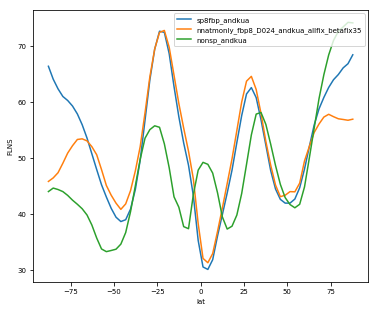

In [388]:
compare_line(lambda d: d['FLNS'].mean('lon'), exps_ak_D024, h0means)

## lat-lon figures

In [326]:
for e in exps_3kw1:
    h0means[e]['vintTPHYSTND'] = vint(h0means[e], 'TPHYSTND', C_P).compute()

In [165]:
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [178]:
def latlon_panels(hdict, func, exps, exp_ref=None, cm_ref='plasma', cm='RdBu_r', unit='Temperature [K]', 
                levels_ref=None, levels=None, clevels=None, clabel_locs=[], clabel_fmt='%.0f', 
                clev_color='white', width=onecol, height=6, titles=None):
    has_ref = int(exp_ref is not None)
    npanels = len(exps) + has_ref
    fig, axs = plt.subplots(npanels, 1, figsize=(width, height), subplot_kw=dict(projection=ccrs.Robinson()))
    
    if has_ref:
        da_ref = func(hdict[exp_ref])
        da_ref = xr.DataArray(
            np.concatenate([da_ref.values, da_ref.values[:, -1][:, None]], 1), 
            dims={'lat': da_ref.lat, 'lon': list(da_ref.lon) + [360.]}, 
            coords={'lat': da_ref.lat, 'lon': list(da_ref.lon) + [360.]})
        da_ref.plot.contourf(ax=axs[0], add_colorbar=False, cmap=cm_ref, levels=levels_ref,
                             transform=ccrs.PlateCarree())

    for ax, exp in zip(axs.flat[has_ref:], exps):
        da = func(hdict[exp]).copy() 
        da = xr.DataArray(
            np.concatenate([da.values, da.values[:, -1][:, None]], 1), 
            dims={'lat': da.lat, 'lon': list(da.lon) + [360.]}, 
            coords={'lat': da.lat, 'lon': list(da.lon) + [360.]})
        if has_ref: 
            da -= da_ref
        im = da.plot.contourf(ax=ax, add_colorbar=False, cmap=cm, levels=levels, transform=ccrs.PlateCarree())
            
#     [ax.set_xticks(gw_lats) for ax in axs.flat]; [ax.set_xticklabels(label_lats) for ax in axs.flat]; 
#     [ax.set_yticks([]) for ax in axs.flat[1:]]; [ax.set_ylabel('') for ax in axs.flat[1:]];
#     axs[0].set_ylabel('Pressure [hPa]'); [ax.set_xlabel('Latitude') for ax in axs.flat]
    if titles is not None: [ax.set_title(titles[i]) for i, ax in enumerate(axs.flat)]
    
    plt.subplots_adjust(wspace=0.03, left=0, right=1.0)
    cb = fig.colorbar(im, ax=axs.flat, pad=0.01, extend='both', use_gridspec=False, orientation='horizontal'); 
    cb.set_label(unit)
    cb.formatter.set_powerlimits((1, 10)); cb.update_ticks()
    cb.ax.yaxis.set_offset_position('left')
    
    return fig, axs

### 3KW1

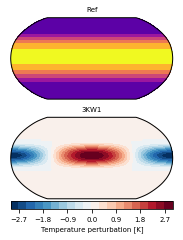

In [328]:
fig, axs = latlon_panels(h0means, lambda d: d['TS'], [exps_3kw1_D024[0]], exp_ref=exps_ak[0],
              titles=['Ref', '3KW1'],
              unit=r'Temperature perturbation [K]', height=4, levels=np.arange(-3, 3.3, 0.3),
              levels_ref=np.arange(270, 310, 5));

In [329]:
pert = h0means[exps_3kw1_D024[0]]['TS'] - h0means[exps_ak[0]]['TS']

In [330]:
tmp = xr.DataArray(np.concatenate([pert.values, pert.values[:, -1][:, None]], 1), 
                   dims={'lat': pert.lat, 'lon': list(pert.lon) + [360.]}, 
                   coords={'lat': pert.lat, 'lon': list(pert.lon) + [360.]})

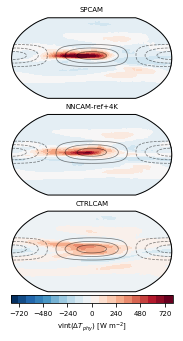

In [331]:
fig, axs = latlon_panels(h0means, lambda d: d['vintTPHYSTND'], exps_3kw1_D024, 
                         unit=r'vint($\Delta T_{phy}$) [W m$^{-2}$]', levels=np.arange(-800, 880, 80));
[tmp.plot.contour(ax=ax, colors='k', linestyles='-', levels=[0.5, 1.5, 2.5], transform=ccrs.PlateCarree(),
                   linewidths=0.75, alpha=0.5) for ax in axs]
[tmp.plot.contour(ax=ax, colors='k', linestyles='--', levels=[-2.5, -1.5, -0.5], transform=ccrs.PlateCarree(),
                   linewidths=0.75, alpha=0.5) for ax in axs];
titles=['SPCAM', 'NNCAM-ref+4K', 'CTRLCAM']
[ax.set_title(titles[i]) for i, ax in enumerate(axs.flat)];

In [183]:
fig.savefig(f'{FIG_DIR}global_vintTPHY_3KW1.pdf')

In [323]:
exps_3kw1_D024, exps_3kw1_D025

(['sp8fbp_3kw1', 'nnatmonly_fbp8_D024_3kw1_allfix_betafix35', 'nonsp_3kw1'],
 ['sp8fbp_3kw1', 'nnatmonly_fbp8_D025_3kw1_allfix_betafix35', 'nonsp_3kw1'])

In [324]:
exps_3kw1

['sp8fbp_3kw1',
 'nnatmonly_fbp8_D024_3kw1_allfix_betafix35',
 'nnatmonly_fbp8_D025_3kw1_allfix_betafix35',
 'nonsp_3kw1']

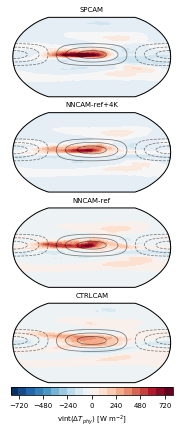

In [333]:
fig, axs = latlon_panels(h0means, lambda d: d['vintTPHYSTND'], exps_3kw1, height=8,
                         unit=r'vint($\Delta T_{phy}$) [W m$^{-2}$]', levels=np.arange(-800, 880, 80));
[tmp.plot.contour(ax=ax, colors='k', linestyles='-', levels=[0.5, 1.5, 2.5], transform=ccrs.PlateCarree(),
                   linewidths=0.75, alpha=0.5) for ax in axs]
[tmp.plot.contour(ax=ax, colors='k', linestyles='--', levels=[-2.5, -1.5, -0.5], transform=ccrs.PlateCarree(),
                   linewidths=0.75, alpha=0.5) for ax in axs];
titles=['SPCAM', 'NNCAM-ref+4K', 'NNCAM-ref', 'CTRLCAM']
[ax.set_title(titles[i]) for i, ax in enumerate(axs.flat)];

In [334]:
savefigs(fig, f'{FIG_DIR}for-mike_global_vintTPHY_3KW1')

### Radiation differences

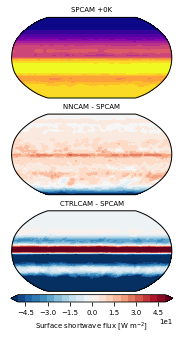

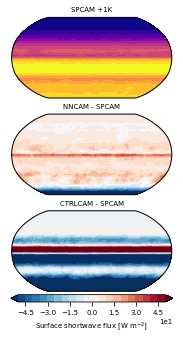

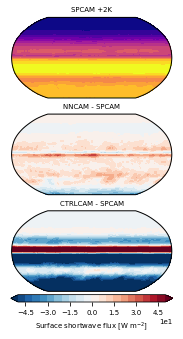

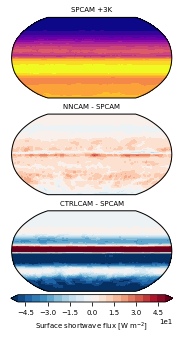

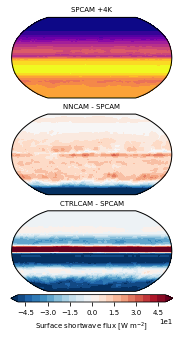

In [188]:
for name, exps in zip(['+0K', '+1K', '+2K', '+3K', '+4K'], 
                      [exps_ak_D024, exps_1k_D024, exps_2k_D024, exps_3k_D024, exps_4k_D024]):
    fig, axs = latlon_panels(h0means, lambda d: d['FSNS'], exps[1:], exps[0], 
                             titles=['SPCAM ' + name, 'NNCAM - SPCAM', 'CTRLCAM - SPCAM'],
                             levels_ref=np.arange(0, 300, 20),
                             levels=np.arange(-50, 55, 5),
                             unit=r'Surface shortwave flux [W m$^{-2}$]');
    fig.savefig(f'{FIG_DIR}globe_FSNS_{name}.pdf')
    plt.show()

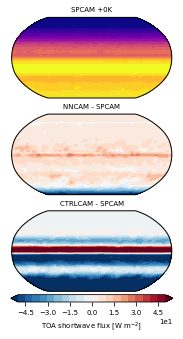

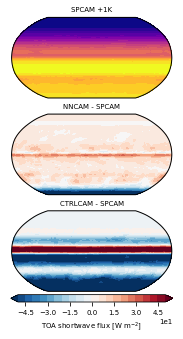

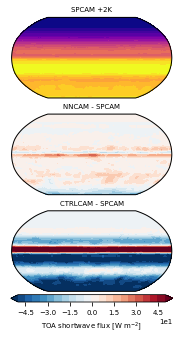

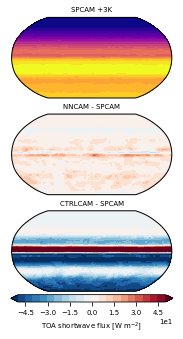

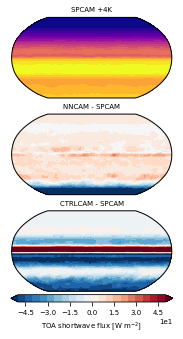

In [194]:
for name, exps in zip(['+0K', '+1K', '+2K', '+3K', '+4K'], 
                      [exps_ak_D024, exps_1k_D024, exps_2k_D024, exps_3k_D024, exps_4k_D024]):
    fig, axs = latlon_panels(h0means, lambda d: d['FSNT'], exps[1:], exps[0], 
                             titles=['SPCAM ' + name, 'NNCAM - SPCAM', 'CTRLCAM - SPCAM'],
                             levels_ref=np.arange(0, 400, 20),
                             levels=np.arange(-50, 55, 5),
                             unit=r'TOA shortwave flux [W m$^{-2}$]');
    fig.savefig(f'{FIG_DIR}globe_FSNT_{name}.pdf')
    plt.show()

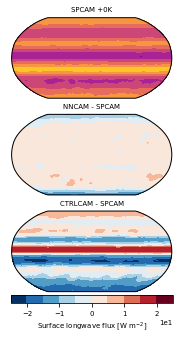

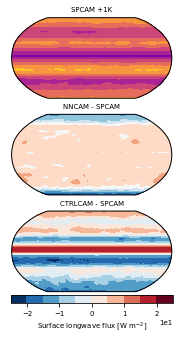

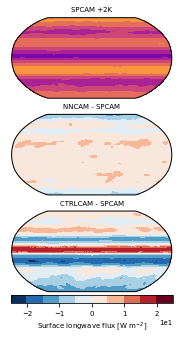

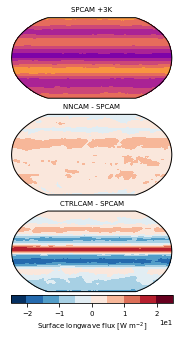

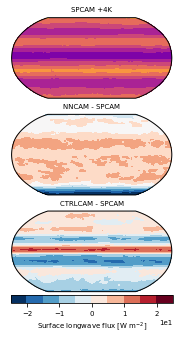

In [193]:
for name, exps in zip(['+0K', '+1K', '+2K', '+3K', '+4K'], 
                      [exps_ak_D024, exps_1k_D024, exps_2k_D024, exps_3k_D024, exps_4k_D024]):
    fig, axs = latlon_panels(h0means, lambda d: d['FLNS'], exps[1:], exps[0], 
                             titles=['SPCAM ' + name, 'NNCAM - SPCAM', 'CTRLCAM - SPCAM'],
                             levels_ref=np.arange(0, 100, 10),
                             levels=np.arange(-25, 30, 5),
                             unit=r'Surface longwave flux [W m$^{-2}$]');
    fig.savefig(f'{FIG_DIR}globe_FLNS_{name}.pdf')
    plt.show()

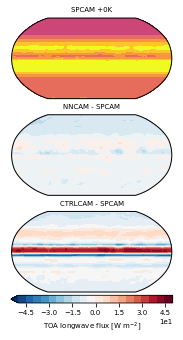

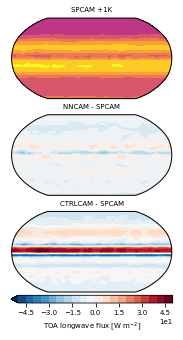

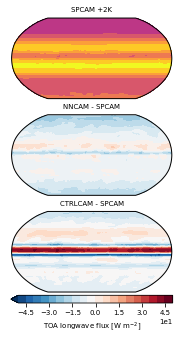

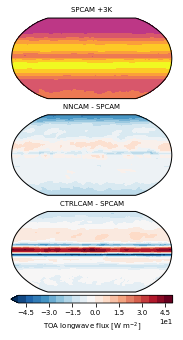

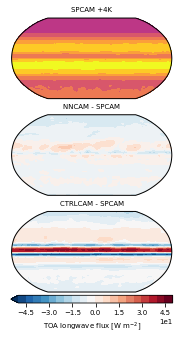

In [192]:
for name, exps in zip(['+0K', '+1K', '+2K', '+3K', '+4K'], 
                      [exps_ak_D024, exps_1k_D024, exps_2k_D024, exps_3k_D024, exps_4k_D024]):
    fig, axs = latlon_panels(h0means, lambda d: d['FLNT'], exps[1:], exps[0], 
                             titles=['SPCAM ' + name, 'NNCAM - SPCAM', 'CTRLCAM - SPCAM'],
                             levels_ref=np.arange(100, 300, 20),
                             levels=np.arange(-50, 55, 5),
                             unit=r'TOA longwave flux [W m$^{-2}$]');
    fig.savefig(f'{FIG_DIR}globe_FLNT_{name}.pdf')
    plt.show()

## Variability

### Std plots

In [86]:
minlev = 3

In [87]:
levs = h1s[exps_ak[0]].lev[minlev:].values

In [156]:
def std_panel(hdict, func, exps, xlabel, xlims):
    fig, ax = plt.subplots(figsize=(onecol, 2.2))
    plt.subplots_adjust(left=0.3, right=0.95, bottom=0.2, top=0.95)
    [plt.plot(func(hdict[exps[i]]), levs, label=e, c=colors[i], lw=2) 
     for i, e in enumerate(['SPCAM', 'NNCAM', 'CTRLCAM'])]
    ax.legend()
    sns.despine()
    ax.set_xlabel(xlabel); ax.set_ylabel(r'Pressure [hPa]')
    ax.ticklabel_format(axis='x', scilimits=(0, 0))
    ax.set_ylim(0, 1000); ax.set_xlim(xlims)
    ax.invert_yaxis()
    return fig

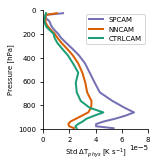

In [157]:
f = std_panel(h1stds, lambda d: d['TPHYSTND'].isel(lev=slice(minlev, None)).mean(('lat', 'lon')), exps_ak_D024,
              r'Std $\Delta$T$_{phys}$ [K s$^{-1}$]', (0, 0.8e-4))

In [158]:
f.savefig(f'{FIG_DIR}std_tphys.pdf')

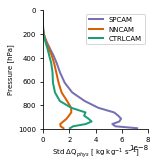

In [159]:
f = std_panel(h1stds, lambda d: d['PHQ'].isel(lev=slice(minlev, None)).mean(('lat', 'lon')), exps_ak_D024,
              r'Std $\Delta$Q$_{phys}$ [ kg kg$^{-1}$ s$^{-1}$]', (0, 0.8e-7))

In [160]:
f.savefig(f'{FIG_DIR}std_phq.pdf')

### Precip hist

In [346]:
prects = {e: h1s[e]['PRECT'].plot(range=(0, 4.5e-6), bins=100, label=e) 
          for e in exps_ak +exps_4k};
plt.close('all')

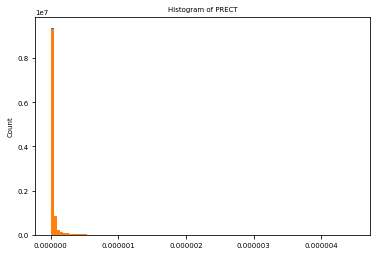

In [374]:
for e in exps_ak_nf:
    prects[e] = h1s[e]['PRECT'].plot(range=(0, 4.5e-6), bins=100, label=e) 

In [347]:
save_tmp('prects', prects)

In [101]:
prects = load_tmp('prects')

In [320]:
colors2 = ['#8da0cb', '#fc8d62', '#66c2a5']
labels = ['SPCAM', 'NNCAM', 'CTRLCAM', '+4K', '+4K', '+4K']

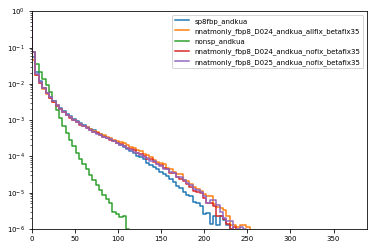

In [377]:
fig, ax = plt.subplots()
[ax.step(prects[e][1][:-1]*1e3*24*3600, prects[e][0]/prects[e][0].sum(), label=e) for e in exps_ak_D024 + exps_ak_nf]
ax.set_ylim(1e-6, 1); 
ax.set_xlim(0, prects[exps[0]][1][-1]*1e3*24*3600);
ax.legend()
ax.set_yscale('log')

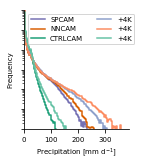

In [349]:
fig, ax = plt.subplots(figsize=(onecol, 2.2))
plt.subplots_adjust(left=0.3, right=0.95, bottom=0.2, top=0.95)
[ax.step(prects[e][1][:-1]*1e3*24*3600, prects[e][0]/prects[e][0].sum(), label=labels[i], c=(colors + colors2)[i], 
         where='post') for i, e in enumerate(exps_ak_D024 + exps_4k_D024)]
ax.set_yscale('log')
ax.legend(ncol=2)
sns.despine()
ax.set_xlabel(r'Precipitation [mm d$^{-1}$]'); ax.set_ylabel(r'Frequency')
#ax.set_title('Precipitation distribution')
#ax.ticklabel_format(axis='x', scilimits=(0, 0))
ax.set_yticklabels([])
ax.set_ylim(1e-6, 1); 
ax.set_xlim(0, prects[exps[0]][1][-1]*1e3*24*3600);

In [350]:
savefigs(fig, 'prec_hist')

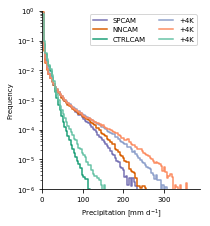

In [352]:
fig, ax = plt.subplots(figsize=(onecol*1.5, 3.3))
plt.subplots_adjust(left=0.3, right=0.95, bottom=0.2, top=0.95)
[ax.step(prects[e][1][:-1]*1e3*24*3600, prects[e][0]/prects[e][0].sum(), label=labels[i], c=(colors + colors2)[i], 
         where='post') for i, e in enumerate(exps_ak_D024 + exps_4k_D024)]
ax.set_yscale('log')
ax.legend(ncol=2)
sns.despine()
ax.set_xlabel(r'Precipitation [mm d$^{-1}$]'); ax.set_ylabel(r'Frequency')
#ax.set_title('Precipitation distribution')
#ax.ticklabel_format(axis='x', scilimits=(0, 0))
ax.set_ylim(1e-6, 1); 
ax.set_xlim(0, prects[exps[0]][1][-1]*1e3*24*3600);

In [355]:
savefigs(fig, 'for_mike-prec_hist')

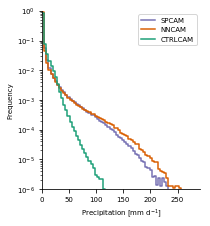

In [358]:
fig, ax = plt.subplots(figsize=(onecol*1.5, 3.3))
plt.subplots_adjust(left=0.3, right=0.95, bottom=0.2, top=0.95)
[ax.step(prects[e][1][:-1]*1e3*24*3600, prects[e][0]/prects[e][0].sum(), label=labels[i], c=(colors + colors2)[i], 
         where='post') for i, e in enumerate(exps_ak_D024)]
ax.set_yscale('log')
ax.legend()
sns.despine()
ax.set_xlabel(r'Precipitation [mm d$^{-1}$]'); ax.set_ylabel(r'Frequency')
#ax.set_title('Precipitation distribution')
#ax.ticklabel_format(axis='x', scilimits=(0, 0))
ax.set_ylim(1e-6, 1); 
ax.set_xlim(0, prects[exps[0]][1][-1]*1e3*24*3600*0.75);

In [359]:
savefigs(fig, 'for_mike-prec_hist_no4k')

## Energy conservation

### Scatter plots

In [297]:
d = h1s[exps_ak_D024[1]]

In [298]:
NNQatm = vint(d, 'NNDQ', 1)
PPQatm = vint(d, 'PPDQ', 1)

In [299]:
NNQsurf = d['NNLHF'] / L_V - d['NNPRECT'] * 1e3
PPQsurf = d['NNLHF'] / L_V - d['PPPRECT'] * 1e3

In [300]:
NNSE = vint(d, 'NNDT', C_P) - d['NNSHF'] - d['NNFSNT'] + d['NNFSNS'] + d['NNFLNT'] - d['NNFLNS']
PPSE = vint(d, 'PPDT', C_P) - d['NNSHF'] - d['PPFSNT'] + d['PPFSNS'] + d['PPFLNT'] - d['PPFLNS']

In [301]:
NNME = d['NNLHF'] - vint(d, 'NNDQ', L_V)
PPME = d['NNLHF'] - vint(d, 'PPDQ', L_V)

In [302]:
a = NNSE.isel(time=slice(0, None, 50)).values.flat
b = NNME.isel(time=slice(0, None, 50)).values.flat

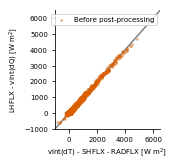

In [303]:
fig, ax = plt.subplots(figsize=(onecol, 2.2))
plt.subplots_adjust(left=0.3, right=0.95, bottom=0.2, top=0.95)
ax.scatter(a, b, alpha=0.5, s=7, color=colors[1], linewidths=0, 
           label='Before post-processing')
sns.despine()
ax.legend()
ax.set_xlabel(r'vint(dT) - SHFLX - RADFLX [W m$^{2}$]'); ax.set_ylabel(r'LHFLX - vint(dQ) [W m$^{2}$]')
#ax.set_title('Heating rate variability')
#ax.ticklabel_format(axis='x', scilimits=(0, 0))
ax.set_ylim(-1e3, 6.5e3); ax.set_xlim(-1e3, 6.5e3)
ax.plot([-1e3, 6.5e3], [-1e3, 6.5e3], zorder=0.1, c='gray');

In [304]:
savefigs(fig, f'{FIG_DIR}engy_scatter')

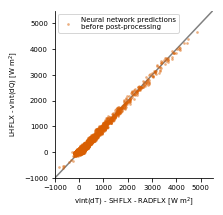

In [305]:
fig, ax = plt.subplots(figsize=(onecol*1.5, 3.1))
plt.subplots_adjust(left=0.3, right=0.95, bottom=0.2, top=0.95)
ax.scatter(a, b, alpha=0.5, s=7, color=colors[1], linewidths=0, 
           label='Neural network predictions\nbefore post-processing')
sns.despine()
ax.legend()
ax.set_xlabel(r'vint(dT) - SHFLX - RADFLX [W m$^{2}$]'); ax.set_ylabel(r'LHFLX - vint(dQ) [W m$^{2}$]')
#ax.set_title('Heating rate variability')
#ax.ticklabel_format(axis='x', scilimits=(0, 0))
ax.set_ylim(-1e3, 5.5e3); ax.set_xlim(-1e3, 5.5e3)
ax.plot([-1e3, 5.5e3], [-1e3, 5.5e3], zorder=0.1, c='gray');

In [306]:
savefigs(fig, f'{FIG_DIR}for_mike-engy_scatter')

#### Same for SP

In [287]:
d = h1s[exps_ak_D024[0]]

In [288]:
d

<xarray.Dataset>
Dimensions:       (chars: 8, crm_x: 8, crm_y: 1, crm_z: 28, ilev: 31, isccp_prs: 7, isccp_prstau: 49, isccp_tau: 7, lat: 64, lev: 30, lon: 128, tbnd: 2, time: 120)
Coordinates:
  * lat           (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 ...
  * lon           (lon) float64 0.0 2.812 5.625 8.438 11.25 14.06 16.88 ...
  * crm_x         (crm_x) float64 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0
  * crm_y         (crm_y) float64 0.0
  * crm_z         (crm_z) float64 992.6 976.3 957.5 936.2 912.6 887.0 859.5 ...
  * lev           (lev) float64 3.643 7.595 14.36 24.61 38.27 54.6 72.01 ...
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 30.67 45.87 63.32 ...
  * isccp_prs     (isccp_prs) float64 90.0 245.0 375.0 500.0 620.0 740.0 900.0
  * isccp_tau     (isccp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 219.5
  * isccp_prstau  (isccp_prstau) float64 90.0 90.0 90.0 90.01 90.02 90.04 ...
  * time          (time) float64 370.0 370.2 370.5 370.8 371.0 371.2 371.5 ...


In [290]:
SPSE = vint(d, 'TPHYSTND', C_P) - d['SHFLX'] - d['FSNT'] + d['FSNS'] + d['FLNT'] - d['FLNS']

In [291]:
SPME = d['LHFLX'] - vint(d, 'PHQ', L_V)

In [292]:
a = SPSE.isel(time=slice(0, None, 50)).values.flat
b = SPME.isel(time=slice(0, None, 50)).values.flat

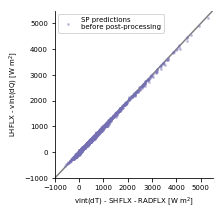

In [294]:
fig, ax = plt.subplots(figsize=(onecol*1.5, 3.1))
plt.subplots_adjust(left=0.3, right=0.95, bottom=0.2, top=0.95)
ax.scatter(a, b, alpha=0.5, s=7, color=colors[0], linewidths=0, 
           label='SP predictions\nbefore post-processing')
sns.despine()
ax.legend()
ax.set_xlabel(r'vint(dT) - SHFLX - RADFLX [W m$^{2}$]'); ax.set_ylabel(r'LHFLX - vint(dQ) [W m$^{2}$]')
#ax.set_title('Heating rate variability')
#ax.ticklabel_format(axis='x', scilimits=(0, 0))
ax.set_ylim(-1e3, 5.5e3); ax.set_xlim(-1e3, 5.5e3)
ax.plot([-1e3, 5.5e3], [-1e3, 5.5e3], zorder=0.1, c='gray');

In [296]:
savefigs(fig, f'{FIG_DIR}for_mike-engy_scatter_sp')

#### Moisture

In [151]:
a = NNQsurf.isel(time=slice(0, None, 50)).values.flat
b = NNQatm.isel(time=slice(0, None, 50)).values.flat

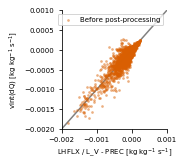

In [152]:
fig, ax = plt.subplots(figsize=(onecol, 2.2))
plt.subplots_adjust(left=0.3, right=0.95, bottom=0.2, top=0.95)
ax.scatter(a, b, alpha=0.5, s=7, color=colors[1], linewidths=0, 
           label='Before post-processing')
sns.despine()
ax.legend()
ax.set_xlabel(r'LHFLX / L_V - PREC [kg kg$^{-1}$ s$^{-1}$]'); ax.set_ylabel(r'vint(dQ) [kg kg$^{-1}$ s$^{-1}$]')
#ax.set_title('Heating rate variability')
#ax.ticklabel_format(axis='x', scilimits=(0, 0))
ax.set_ylim(-2e-3, 1e-3); ax.set_xlim(-2e-3, 1e-3)
ax.plot([-2e-3, 1e-3], [-2e-3, 1e-3], zorder=0.1, c='gray');

In [153]:
fig.savefig(f'{FIG_DIR}moisture_scatter.pdf')

### TE/TW timeseries

In [141]:
TEs = {e: gw_avg(d, 'TE').compute() for e, d in h0s.items()}
TWs = {e: gw_avg(d, 'TW').compute() for e, d in h0s.items()}
save_tmp('TEs', TEs); save_tmp('TWs', TWs)

In [142]:
TEs, TWs = load_tmp('TEs'), load_tmp('TWs')

In [143]:
def plot_ts(hdict, func, exps, labels, colors, ylabel):
    fig, ax = plt.subplots(figsize=(twocols, 2.2))
    plt.subplots_adjust(left=0.2, right=0.95, bottom=0.2, top=0.95)
    t = np.arange(len(func(hdict[exps[0]]).time.values))
    t = t / 12
    [plt.plot(t, func(hdict[e]), label=labels[i], c=colors[i]) for i, e in enumerate(exps)]
    ax.set_xlabel('Time [y]'); ax.set_ylabel(ylabel)
    sns.despine()
    ax.legend(ncol=2)
    return fig

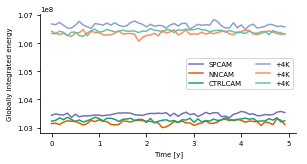

In [144]:
f = plot_ts(TEs, lambda d: d, exps_ak_D024 + exps_4k_D024, labels,
        colors + colors2, ylabel='Globally integrated energy')

In [145]:
f.savefig(f'{FIG_DIR}TE_timeseries.pdf')

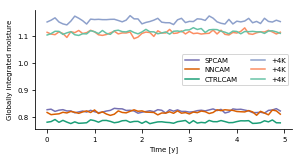

In [146]:
f = plot_ts(TWs, lambda d: d, exps_ak_D024 + exps_4k_D024, labels,
        colors + colors2, ylabel='Globally integrated moisture')

In [147]:
f.savefig(f'{FIG_DIR}TW_timeseries.pdf')

## W-K diagram

In [222]:
WK_DATA = '/beegfs/DATA/pritchard/srasp/wkdata/'
!ls {WK_DATA}

SpaceTime.PRECT.nnatmonly_fbp8_D024_3kw1_allfix_betafix35.nc
SpaceTime.PRECT.nnatmonly_fbp8_D024_4k_allfix_betafix35.nc
SpaceTime.PRECT.nnatmonly_fbp8_D024_andkua_allfix_betafix35.nc
SpaceTime.PRECT.nonsp_3kw1.nc
SpaceTime.PRECT.nonsp_4k.nc
SpaceTime.PRECT.nonsp_andkua.nc
SpaceTime.PRECT.sp8fbp_3kw1.nc
SpaceTime.PRECT.sp8fbp_4k.nc
SpaceTime.PRECT.sp8fbp_andkua.nc


In [223]:
wks = [xr.open_dataset(f'{WK_DATA}SpaceTime.PRECT.{e}.nc') for e in exps_ak_D024 + exps_4k_D024]

In [224]:
wks = [wk.isel(freq=slice(1, None)) for wk in wks]

In [225]:
freq_days = 1/wks[0].freq

In [226]:
labels_days = [30, 6, 3, 2]
labels_freq = 1/np.array(labels_days)

In [227]:
hs = [12, 25, 50]
g = 9.81

In [228]:
def ER(k, h):
    n = 1; lat = 0.
    Beta = 2. * 7.292E-5 * np.cos(abs(lat)) / 6.37E6
    t4 = (Beta / np.ma.sqrt(g * h)) * (2 * n + 1.)
    return -Beta * k / (k * k + t4)

In [229]:
lat = 0.
ll = 2. * np.pi * 6.37E6 * np.cos(abs(lat))

In [232]:
k = 2 * np.pi * wks[0].wave / ll

In [233]:
def tofreq(x): return 1/(2 * np.pi / (x * 24 * 60 * 60))

In [307]:
def wk_panel(ax, data, title, add_text=True, **kwargs):
    im = ax.contourf(data.wave, data.freq, data['FIG_3_SYM'], **kwargs)
    ax.set_yticks(labels_freq); ax.set_yticklabels(labels_days);
    [ax.axhline(y, linestyle='--', c='gray', zorder=1.1, linewidth=0.75, alpha=0.5) for y in labels_freq]
    [ax.plot(data.wave, tofreq(k*np.sqrt(g * h)), c='gray', lw=0.7, alpha=0.5) for h in hs];
    [ax.plot(data.wave, tofreq(ER(k, h)), c='gray', lw=0.7, alpha=0.5) for h in hs];
    ax.set_xlim(data.wave[0], data.wave[-1]); ax.set_ylim(data.freq[0], data.freq[-1]);
    if add_text:
        ax.text(7, 1/2.4, 'Kelvin', color='white', weight='bold', fontsize=6, zorder=2);
        ax.text(-14, 1/15, 'n=1 ER', color='white', weight='bold', fontsize=6, zorder=2);
        ax.text(4, 1/28, 'MJO', color='white', weight='bold', fontsize=6, zorder=2);
    ax.set_xlabel('Zonal wave number'); ax.set_ylabel('Period [days]')
    ax.set_title(title)
    ax.set_xticks([-10, -5, 0, 5, 10])
    return im

In [308]:
titles = ['SPCAM', 'NNCAM', 'CTRLCAM']

In [309]:
def wk_panels(data):
    fig, axs = plt.subplots(1, 3, figsize=(twocols, 2.2))
    for i, (ax, wk) in enumerate(zip(axs.flat, data)):
        im = wk_panel(ax, wk, titles[i], True if i == 0 else False, cmap='plasma', 
                      levels=np.arange(1, 2.2, 0.1), extend='both')
        if i > 0: ax.set_ylabel(''); ax.set_yticks([])
    plt.subplots_adjust(wspace=0.03, left=0.1, right=1.0, bottom=0.2)
    cb = fig.colorbar(im, ax=axs, pad=0.01); cb.set_label('Log power spectrum')
    return fig

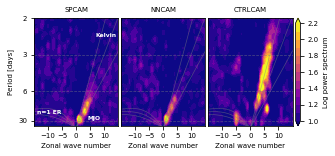

In [310]:
f = wk_panels(wks[:3])

In [312]:
savefigs(f, f'{FIG_DIR}for_mike-wk_ref')

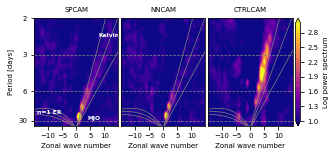

In [253]:
f = wk_panels(wks[3:])

In [254]:
f.savefig(f'{FIG_DIR}wk_4k.pdf')